<a href="https://colab.research.google.com/github/deeppatel1842/BTP/blob/main/SCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import torch
from torch.autograd import Variable
import matplotlib.image as mpimg
import torch.nn as nn

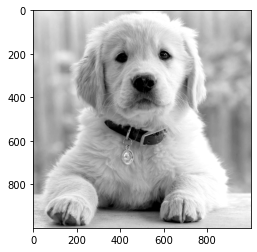

In [ ]:
image = mpimg.imread('/content/sample_data/dog2.jpeg')
image = image[:,:,0]
plt.imshow(image, cmap='gray')

image = image[np.newaxis, np.newaxis, :, :]

In [ ]:
def maxpool(image): 
    m = torch.nn.MaxPool2d(3, stride=2)
    img_tensor = Variable(torch.from_numpy(image).float())
    pooled = m(img_tensor)
    return np.squeeze(pooled.data.numpy())

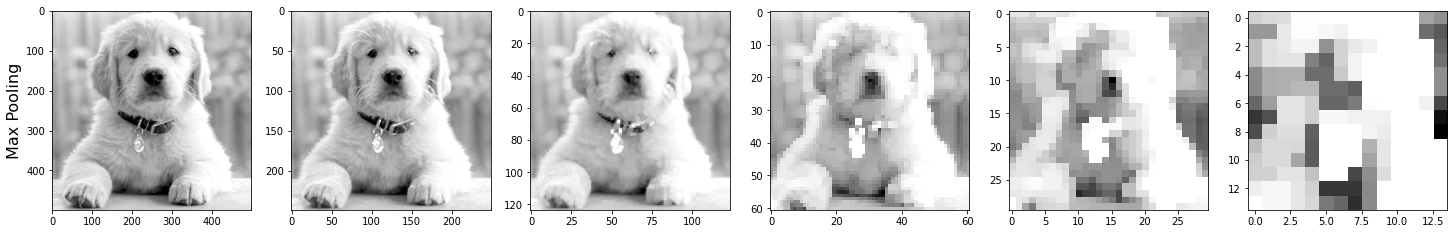

In [ ]:
fig, axes = plt.subplots(1,6,figsize=(25,5))
for i in range(6): 
    ax = axes[i]
    image = maxpool(image)
    ax.imshow(image, cmap='gray')
    image = image[np.newaxis, np.newaxis, :, :]
    if not i:
        ax.set_ylabel('Max Pooling', fontsize=16)

In [ ]:
import numpy as np
import itertools

def _crop_spectrum(y, filter_height, filter_width): 
   
    image_height = y.shape[2]
    image_width = y.shape[3]
    
    
    height_i = int(np.ceil((image_height - filter_height) / 2))
    height_j = image_height - height_i 
    
    width_i = int(np.ceil((image_width - filter_width) / 2))
    width_j = image_width - width_i
    
    return y[:,:,height_i:height_j,width_i:width_j] 

    
def _treat_corner_cases(y): 
  
    M = y.shape[2]
    N = y.shape[3] 
    index = list() 
    
    if M % 2 == 0: 
        M = M // 2
    if N % 2 == 0: 
        N = N // 2 
        
    MN_indices = itertools.product(range(M), range(N)) 
    for mn in MN_indices:
        y[:,:,mn[0],mn[1]] = np.real(y[:,:,mn[0],mn[1]])  
        index.append(mn) 
    return y, index



In [ ]:
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn.functional as F

try:
    import pytorch_fft.fft as fft    #FastFourier Transform (FFT)
except ModuleNotFoundError: 
    pass
    

class spectral_pool(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, input, filter_height, filter_width):
        
        # convert to numpy to use fft 
        if not isinstance(input, np.ndarray): 
            input = input.numpy() 
        y_spectral = np.fft.fft2(input) 
        # center the frequency 
        y_spectral = np.fft.fftshift(y_spectral)     
        
        y_spectral = _crop_spectrum(y_spectral, filter_height, filter_width) 
        y_spectral,_ = _treat_corner_cases(y_spectral) 
        cropped = np.abs(np.fft.ifft2(y_spectral))
        return torch.from_numpy(cropped)



In [ ]:
class SpectralPool(nn.Module):
    """Spectral pooling layer."""
    
    def __init__(self, filter_height, filter_width):
        super(SpectralPool, self).__init__()
        self.filter_height = filter_height
        self.filter_width = filter_width
        
    def forward(self, input): 
        return spectral_pool.apply(input, self.filter_height, self.filter_width)


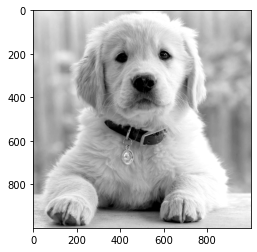

In [ ]:
image2 = mpimg.imread('/content/sample_data/dog2.jpeg')
image2 = image2[:,:,0]
plt.imshow(image2, cmap='gray')

image2 = image2[np.newaxis, np.newaxis, :, :]

In [ ]:
def spectralpool(image, filter_height, filter_width): 
    spectral_pool = SpectralPool(filter_height, filter_width)
    img_var = spectral_pool.forward(image2)
    return np.squeeze(img_var.data.numpy())

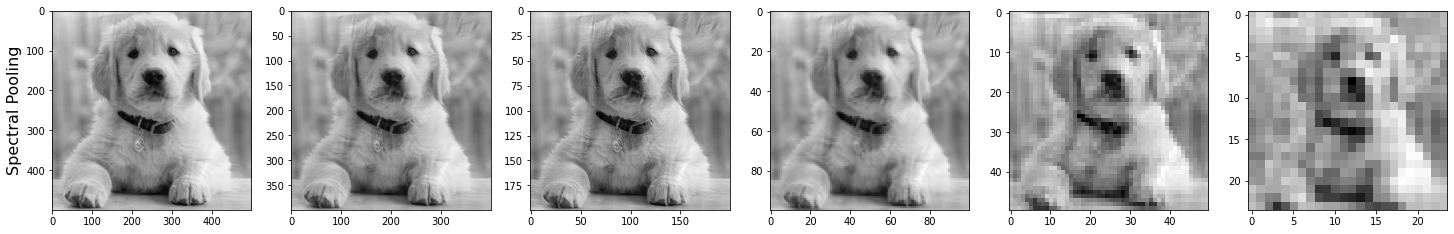

In [ ]:
filter_size = [500, 400, 200, 100, 50, 25]

fig, axes = plt.subplots(1,6, figsize=(25,5))
for i in range(6): 
    ax = axes[i]
    image2 = spectralpool(image2,filter_size[i],filter_size[i])
    ax.imshow(image2, cmap='gray')
    image2 = image2[np.newaxis, np.newaxis, :, :]
    if not i:
        ax.set_ylabel('Spectral Pooling', fontsize=16)